In [1]:
import pandas as pd 
import numpy as np
import math
import matplotlib.pyplot as plt
plt.style.use('seaborn-paper')

import biopandas.pdb as pandaspdb
import os

# Read in the data
# id = '2zta'            
# id = '2m59'
# id = '7sk0'    # too many hetatms in this pdb file
# id = '7sk1'
# id = '1afo' 
# id = '3cap'
# id = '1f88'
# id = '3d4i'
# id = '1cx8'
# id = '7vu5'    
# id = '4riw'    # this is not a good model to use (not truly a binary interaction)
# id = '3q5w'
# id = '2bjn'
# id = '6ofj'

id = '8GTK'
# change if the protein in transmembrane or cytosolic
# dielectric constant for transmembrane = 4
# dielectric constant for cytosolic = 29

DIELEC = 4
# DIELEC = 29

N_PLANES = 16               # number of planes used to section the protein in the z-axis
print(os.getcwd())
pdb_file_dir = './pdb_files'
interchain_intr_dir = './elec_intr_files'
vdw_intr_dir = './vdw_intr_files'

interchain_intr = pd.read_csv(os.path.join(interchain_intr_dir, f'elec_intr_{id}.csv'))
vdw_intr = pd.read_csv(os.path.join(vdw_intr_dir, f'vdw_intr_{id}.csv'))


/Users/aaditmahajan/Documents/binary-interfaces/workflow


In [2]:
def generate_z_planes(interchain_intr, N_PLANES) -> list[float]:
    z_values = []
    for i in range(len(interchain_intr)):
        z_values.append(interchain_intr.atom1_zcoord.iloc[i])
        z_values.append(interchain_intr.atom2_zcoord.iloc[i])

    z_values = np.array(z_values)
    z_planes = list(np.linspace(z_values.min(), z_values.max(), N_PLANES))
    z_planes.sort()
    return z_planes

In [3]:
def get_blockdet(z_planes, interchain_intr, vdw_intr) -> np.array:
    blockdet = []
    for i in range(len(interchain_intr)):
        z1 = interchain_intr.atom1_zcoord.iloc[i]
        z2 = interchain_intr.atom2_zcoord.iloc[i]
        z1_idx = np.digitize(z1, z_planes)
        z2_idx = np.digitize(z2, z_planes)
        res1 = int(interchain_intr.atom1.iloc[i])
        res2 = int(interchain_intr.atom2.iloc[i])
        if z1_idx == z2_idx:
            blockdet.append((res1, res2, z1_idx))
        else:
            blockdet.append((res1, res2, z2_idx))
    
    for i in range(len(vdw_intr)):
        z1 = vdw_intr.atom1_zcoord.iloc[i]
        z2 = vdw_intr.atom2_zcoord.iloc[i]
        z1_idx = np.digitize(z1, z_planes)
        z2_idx = np.digitize(z2, z_planes)
        res1 = int(vdw_intr.atom1.iloc[i])
        res2 = int(vdw_intr.atom2.iloc[i])
        if z1_idx == z2_idx:
            blockdet.append((res1, res2, z1_idx))
        else:
            blockdet.append((res1, res2, z2_idx))
    
    blockdet = np.array(list(set(blockdet)))
    blockdet = blockdet[blockdet[:, 2].argsort()]
    return blockdet

blockdet = get_blockdet(generate_z_planes(interchain_intr, N_PLANES), interchain_intr, vdw_intr)

In [4]:
def get_vdw_intr_sections(vdw_intr, section_boundaries) -> pd.DataFrame:
    
    # generate partitions
    part_1 = pd.cut(vdw_intr['atom1_zcoord'], bins=section_boundaries, labels=False)
    part_2 = pd.cut(vdw_intr['atom2_zcoord'], bins=section_boundaries, labels=False)

    # handle nan values 
    part_1 = part_1.fillna(-1)
    part_2 = part_2.fillna(-1)

    # assign section number to the atoms if both atoms are in the same section
    for i in range(len(vdw_intr)):
        p1 = int(part_1.iloc[i])
        p2 = int(part_2.iloc[i])

        # if p1 == p2, assign the section number to both atoms, else push to section of atom2
        if p1 == p2:
            vdw_intr.at[i, 'section'] = p1
        else:
            vdw_intr.at[i, 'section'] = p2
    
    return vdw_intr

def get_interchain_intr_sections(interchain_intr, section_boundaries) -> pd.DataFrame:
    p1 = pd.cut(interchain_intr['atom1_zcoord'], bins=section_boundaries, labels=False)
    p2 = pd.cut(interchain_intr['atom2_zcoord'], bins=section_boundaries, labels=False)

    # handle nan values 
    p1 = p1.fillna(-1)
    p2 = p2.fillna(-1)
    
    for i in range(len(interchain_intr)):
        p1_val = int(p1.iloc[i])
        p2_val = int(p2.iloc[i])

        # same logic as above. If both atoms are in the same section, assign the section number to both atoms
        if p1_val == p2_val:
            interchain_intr.at[i, 'section'] = p1_val
        else:
            interchain_intr.at[i, 'section'] = p2_val

    return interchain_intr

def calc_elec_intr_energy(interchain_intr, DIELEC) -> pd.DataFrame:
    interchain_intr['intene'] = (332*4.184*interchain_intr['atom1_chg']*interchain_intr['atom2_chg'])/(DIELEC*interchain_intr['distance'])
    return interchain_intr

In [5]:
import numpy as np
import pandas as pd

def get_sw_values2(master_matrix, elec_intr, vdw_intr, temp) -> pd.DataFrame:
    VDW_INT_ENE = -77.75/1000  
    DCP = -0.3112/1000  # arbitrary value for now
    T_REF = 385
    R = 8.314/1000
    IS = 0.043
    
    # Pre-calculate constants
    ISfac = 5.66 * np.sqrt(IS/temp) * np.sqrt(80/29)
    exp_ISfac = np.exp(-ISfac)
    solv_energy_const = DCP * (temp - T_REF) - temp * DCP * np.log(temp/T_REF)
    
    # Group data
    vdw_intr_sec_grp = vdw_intr.groupby('section')
    elec_intr_sec_grp = elec_intr.groupby('section')
    
    # Pre-calculate sums and counts
    elec_sums = elec_intr_sec_grp['intene'].sum()
    vdw_counts = vdw_intr_sec_grp.size()
    
    def calculate_sw_partial(row):
        if row['type'] == 1:
            elems_in_comb = range(int(row['start1']), int(row['end1'])+1)
        else:
            elems_in_comb = list(range(int(row['start1']), int(row['end1'])+1)) + list(range(int(row['start2']), int(row['end2'])+1))
        
        elec_intene_tot_part = sum(elec_sums.get(elem, 0) for elem in elems_in_comb)
        vdw_counts_part = sum(vdw_counts.get(elem, 0) for elem in elems_in_comb)
        
        elec_intene_tot_part *= exp_ISfac
        vdw_intene_tot_part = vdw_counts_part * VDW_INT_ENE
        solv_energy = vdw_counts_part * solv_energy_const
        deltaE_part = vdw_intene_tot_part + elec_intene_tot_part + solv_energy
        
        return np.exp(-(deltaE_part / (R * temp)))
    
    master_matrix['sw_part'] = master_matrix.apply(calculate_sw_partial, axis=1)
    
    return master_matrix


In [6]:
def generate_master_mat(section_boundaries) -> pd.DataFrame:
    n = len(section_boundaries) + 1
    master_matrix = pd.DataFrame(columns=['struct_elem', 'sw_part', 'start1', 'end1', 'start2', 'end2', 'type'])
    for i in range(n):
        for j in range(i, n):
            if j-i >= 0:
                master_matrix.loc[len(master_matrix)] = [j-i, 0, i, j, 0, 0, 1]
            for k in range(j, n):
                for l in range(k, n):
                    if j-i >= 0 and k-j > 1 and l-k >= 0:
                        master_matrix.loc[len(master_matrix)] = [(j-i) + (l-k), 0, i, j, k, l, 2]

    return master_matrix


In [7]:
# Boilerplate code

VDW_INT_ENE = 0# arbitrary value for now
DCP = 0 # arbitrary value for now
T_REF = 298
min_temp = 278
max_temp = 368
temp_step = 10
R = 8.314/1000

g_vecs = pd.DataFrame()

# 1. generate z_planes
z_planes = generate_z_planes(interchain_intr, N_PLANES)

# 2. generate master_matrix
master_matrix = generate_master_mat(z_planes)

# 3. get sections for vdw_intr
vdw_intr = get_vdw_intr_sections(vdw_intr, z_planes)

# 4. get sections for elec_intr
interchain_intr = get_interchain_intr_sections(interchain_intr, z_planes)

# 5. calculate elec_intr_energy
interchain_intr = calc_elec_intr_energy(interchain_intr, DIELEC)

# 6. get sw_values
for temp in range(min_temp, max_temp + temp_step, temp_step):
    fin_master_matrix = get_sw_values2(master_matrix, interchain_intr, vdw_intr, temp)
    z_part_total = list(fin_master_matrix.groupby('struct_elem').sw_part.sum())
    z_total = sum(z_part_total)
    p_vec = [i/z_total for i in z_part_total]
    g_vec = [-R*temp*math.log(i) for i in p_vec]
    g_vecs[temp] = g_vec

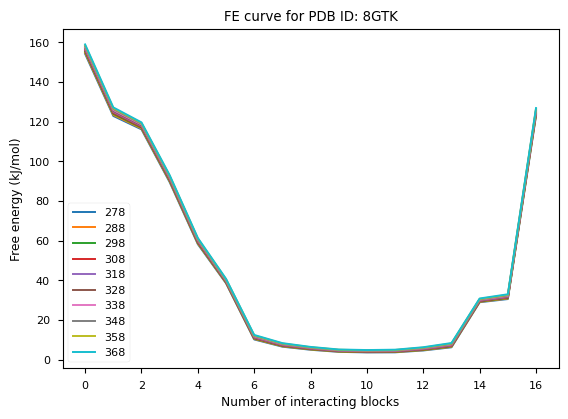

In [8]:
def plot_g_vecs(g_vecs, temps, id, save = False):
    for temp in temps:
        plt.plot(g_vecs[temp])
    plt.legend(temps)
    plt.title(f'FE curve for PDB ID: {id}')
    plt.xlabel('Number of interacting blocks')
    plt.ylabel('Free energy (kJ/mol)')
    if save:
        plt.savefig(f'../plots/FE_curve_{id}.jpg')
    plt.show()

plot_g_vecs(g_vecs, range(min_temp, max_temp + temp_step, temp_step), id, save = False)


In [9]:
import plotly.graph_objects as go 

z = g_vecs

fig = go.Figure(data=[go.Surface(x=g_vecs.columns, y=np.linspace(1, N_PLANES, N_PLANES), z=z.values)])
fig.update_layout(title='Free Energy Landscape',
                  scene=dict(xaxis_title='Temperature (K)', yaxis_title='Structured Elems', zaxis_title='Free Energy (kJ/mol)'),
                  width=750, height=750, autosize = False,
                  margin=dict(l=65, r=50, b=65, t=90)
                  )

In [10]:
#  save g_vecs to a csv file
import os

os.makedirs('./g_vecs', exist_ok=True)
g_vecs.to_csv(f'./g_vecs/{id}_g_vecs.csv', index=False)

# master matrix to csv
os.makedirs('./master_matrices', exist_ok=True)
fin_master_matrix.to_csv(f'./master_matrices/{id}_master_matrix.csv', index=False)


In [11]:
# analysis of free energy values based on the structured elements
struct_group = fin_master_matrix.groupby('struct_elem')

# get the structured elements with minimum free energy values
min_g_vals = g_vecs.min(axis='index')
print(min_g_vals)

# for each temperature, get the no of structured elements with minimum free energy values
min_g_vals_struct_elems = []
for temp in g_vecs.columns:
    min_g = min_g_vals[temp]
    min_g_vals_struct_elems += (g_vecs[temp].index[g_vecs[temp] == min_g].tolist())

min_g_vals_struct_elems = set(min_g_vals_struct_elems)
print('minimum free energy values occur when the number of structured elements interacting are :', min_g_vals_struct_elems)

278    3.609206
288    3.740592
298    3.872142
308    4.003855
318    4.135732
328    4.267772
338    4.399975
348    4.532339
358    4.664865
368    4.797551
dtype: float64
minimum free energy values occur when the number of structured elements interacting are : {10}


In [12]:
min_g_vals_groups = struct_group.get_group(min_g_vals_struct_elems.pop())
for elem in min_g_vals_struct_elems:
    min_g_vals_groups = pd.concat([min_g_vals_groups, struct_group.get_group(elem)])

/var/folders/7l/2100442d14j36v6s7s59lflm0000gn/T/ipykernel_58891/3899197965.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/7l/2100442d14j36v6s7s59lflm0000gn/T/ipykernel_58891/3899197965.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



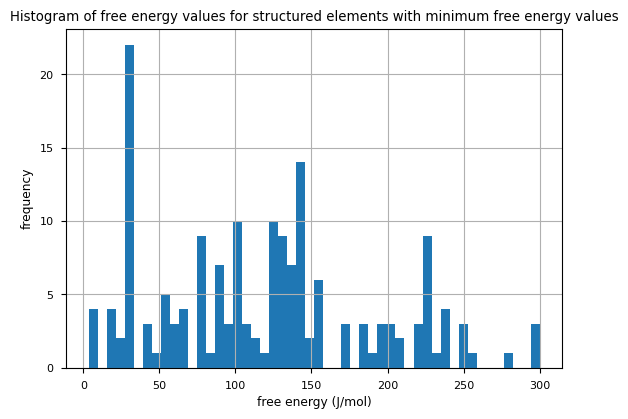

In [14]:
min_g_val_group_z_total = min_g_vals_groups.sw_part.sum()
min_g_vals_groups['partial_z'] = min_g_vals_groups.sw_part/min_g_val_group_z_total
min_g_vals_groups['g_part'] = [-R*temp*math.log(i) for i in min_g_vals_groups.partial_z]

plt.hist(min_g_vals_groups['g_part'], bins=50)
plt.grid()
plt.xlabel('free energy (J/mol)')
plt.ylabel('frequency')
plt.title('Histogram of free energy values for structured elements with minimum free energy values')
plt.show()

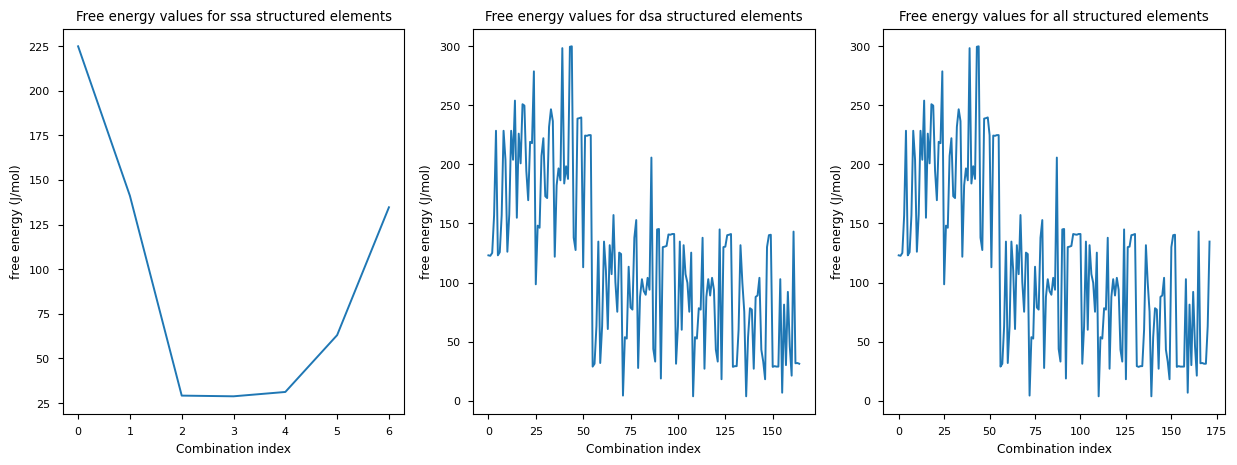

In [15]:
def get_struct_elem_list(master_matrix) -> list:
    struct_elem_list = []
    for i in range(len(master_matrix)):
        start1 = int(master_matrix.iloc[i].start1)
        end1 = int(master_matrix.iloc[i].end1)
        start2 = int(master_matrix.iloc[i].start2)
        end2 = int(master_matrix.iloc[i].end2)
        comb_type = master_matrix.iloc[i].type
        if comb_type == 1:
            elems_in_comb = list(range(start1, end1))
        elif comb_type == 2:
            elems_in_comb = list(range(start1, end1)) + list(range(start2, end2))
        struct_elem_list.append(elems_in_comb)

    return struct_elem_list

# separate ssa entries from the master matrix (type 1)
ssa_entries = min_g_vals_groups[min_g_vals_groups.type == 1].reset_index()
dsa_entries = min_g_vals_groups[min_g_vals_groups.type == 2].reset_index()
total_entries = min_g_vals_groups.reset_index()
struct_elem_list = get_struct_elem_list(min_g_vals_groups)

fig = plt.figure(figsize=(15, 5))
ax1 = plt.subplot(1, 3, 1)
ax1.plot(ssa_entries.g_part)
plt.ylabel('free energy (J/mol)')
plt.title('Free energy values for ssa structured elements')
plt.xlabel('Combination index')

ax2 = plt.subplot(1, 3, 2)
ax2.plot(dsa_entries.g_part)
plt.ylabel('free energy (J/mol)')
plt.title('Free energy values for dsa structured elements')
plt.xlabel('Combination index')

ax3 = plt.subplot(1, 3, 3)
ax3.plot(total_entries.g_part)
plt.ylabel('free energy (J/mol)')
plt.title("Free energy values for all structured elements")
plt.xlabel('Combination index')

plt.show()



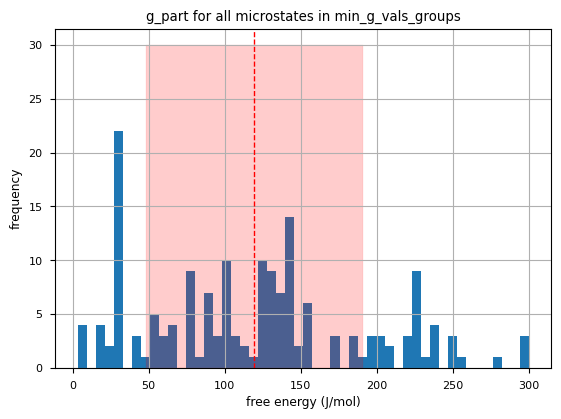

In [ ]:
mean_g_part_total = total_entries.g_part.mean()
std_g_part_total = total_entries.g_part.std()

plt.hist(total_entries.g_part, bins=50)
plt.axvline(mean_g_part_total, color='r', linestyle='dashed', linewidth=1)
plt.fill_betweenx([0, 30], mean_g_part_total - std_g_part_total, mean_g_part_total + std_g_part_total, color='r', alpha=0.2)
plt.grid()
plt.xlabel('free energy (J/mol)')
plt.ylabel('frequency')
plt.title('g_part for all microstates in min_g_vals_groups')
plt.show()

# plotting this just to check if there are any indications of a two state like system. (may or may not be useful)


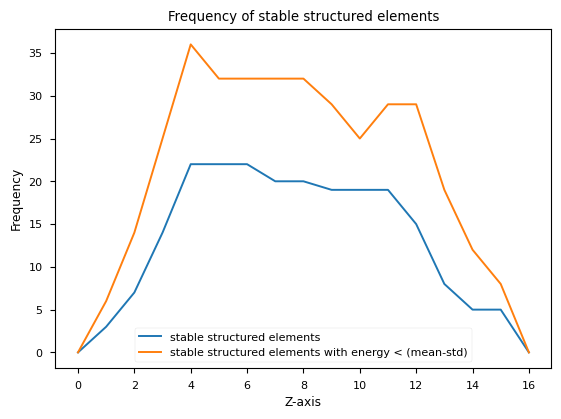

In [ ]:
hist = np.histogram(total_entries.g_part, bins = 50)
max_freq = max(hist[0])
max_freq_idx = np.where(hist[0] == max_freq)[0][0]

# boundaries of the bins with the highest frequency
bin_start = hist[1][max_freq_idx]
bin_end = hist[1][max_freq_idx+1]

# microstates which fall within the boundaries of the bins with the highest frequency
stable_struct_elems_freq = total_entries[(total_entries.g_part >= bin_start) & (total_entries.g_part <= bin_end)]
stable_struct_elems_cond = total_entries[(total_entries.g_part < (mean_g_part_total - std_g_part_total))]

stable_struct_elems_list = get_struct_elem_list(stable_struct_elems_freq)
stable_struct_elems_list_cond = get_struct_elem_list(stable_struct_elems_cond)

# print('stable structured elements:', stable_struct_elems_list)
# print(len(stable_struct_elems_list))
se_freq_stable = {}
se_freq_stable_cond = {}

for i in range(len(stable_struct_elems_list)):
    temp = stable_struct_elems_list[i]
    se_list = np.zeros(N_PLANES+1)
    for elem in temp:
        se_list[elem] += 1
    se_freq_stable[i] = se_list

for i in range(len(stable_struct_elems_list_cond)):
    temp = stable_struct_elems_list_cond[i]
    se_list = np.zeros(N_PLANES+1)
    for elem in temp:
        se_list[elem] += 1
    se_freq_stable_cond[i] = se_list

se_freq_stable_df = pd.DataFrame(se_freq_stable)
se_freq_stable_cond_df = pd.DataFrame(se_freq_stable_cond)

counts = se_freq_stable_df.sum(axis=1)
counts_cond = se_freq_stable_cond_df.sum(axis=1)
plt.plot(counts)
plt.plot(counts_cond)
plt.legend(['stable structured elements', 'stable structured elements with energy < (mean-std)'])
plt.title('Frequency of stable structured elements')
plt.xlabel('Z-axis')
plt.ylabel('Frequency')
plt.show()

In [ ]:
pdb = pandaspdb.PandasPdb() 
pdb.read_pdb(f'{pdb_file_dir}/{id}.pdb')

pdb_df = pdb.df['ATOM']
sections = []
for i in range(len(pdb_df)):
    z = pdb_df.z_coord.iloc[i]
    section = np.digitize(z, z_planes)
    sections.append(section)

temp = []
for section in sections:
    temp.append(counts[section])

pdb_df.b_factor = temp
pdb.to_pdb(path=f'../mod_pdb_files/{id}_se_freq_stable.pdb', records=['ATOM'])

In [ ]:
display(min_g_vals_groups)

,struct_elem,sw_part,start1,end1,start2,end2,type,partial_z,g_part
11,10,3.075667e+30,0,0,2,12,2,3.445817e-18,123.022661
26,10,3.491701e+30,0,0,3,13,2,3.911920e-18,122.634504
40,10,1.574984e+30,0,0,4,14,2,1.764530e-18,125.070347
53,10,4.743394e+25,0,0,5,15,2,5.314251e-23,156.921562
65,10,3.203116e+15,0,0,6,16,2,3.588604e-33,228.571618
...,...,...,...,...,...,...,...,...,...
2414,10,2.736199e+43,4,13,15,16,2,3.065494e-05,31.797057
2416,10,3.352000e+43,4,14,0,0,1,3.755407e-05,31.176005
2417,10,3.352000e+43,4,14,16,16,2,3.755407e-05,31.176005
2650,10,1.009525e+39,5,15,0,0,1,1.131019e-09,63.027220


In [ ]:
print(min_g_vals_struct_elems)

set()


In [ ]:
# get the structured elements with minimum free energy values
min_g_vals_struct_elems = []
for temp in g_vecs.columns:
    min_g = min_g_vals[temp]
    min_g_vals_struct_elems += (g_vecs[temp].index[g_vecs[temp] == min_g].tolist())


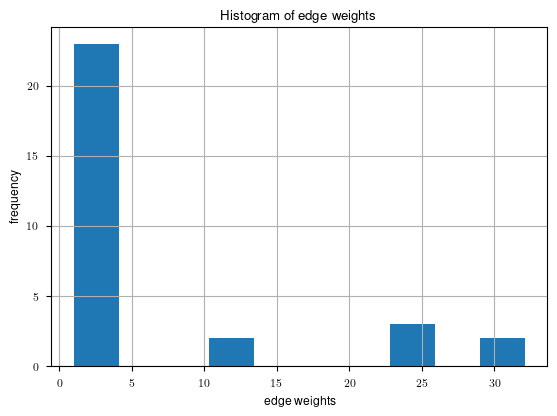

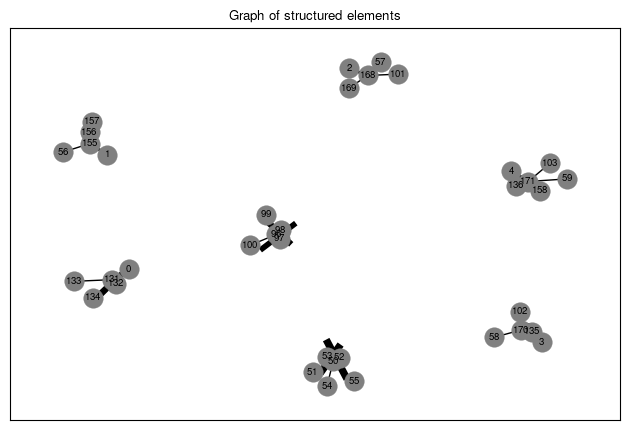

In [ ]:
import networkx as nx 
from Levenshtein import distance

def get_struct_elem_string(struct_elem_list, N_PLANES) -> list:
    struct_elem_str = []
    for entry in struct_elem_list:
        temp = np.zeros(N_PLANES+1)
        for elem in entry:
            temp[elem] = 1

        struct_elem_str.append(''.join([str(int(i)) for i in temp]))
    return struct_elem_str

def calc_edge_weight(g1, g2, t=10) -> float:
    '''
    This maps the difference in free energy values to an edge weight. 
    The molecule should have higher chance of switching between conformations that have similar free energy values.
    hence the edge weights have been defined as the reciprocal of the square root of the difference in free energy values.
    this makes two conformations that have close free energy values to have a higher edge weight and vice versa.
    '''
    
    diff = abs(g1 - g2)
    if diff == 0:
        return 1
    return t/math.sqrt(diff)

def get_graph(struct_elem_str, min_g_vals_groups) -> nx.Graph:
    G = nx.Graph()
    for i in range(len(struct_elem_str)):
        for j in range(i+1, len(struct_elem_str)):
            dist = distance(struct_elem_str[i], struct_elem_str[j])
            if dist == 1:
                edge_weight = calc_edge_weight(min_g_vals_groups.iloc[i].g_part, min_g_vals_groups.iloc[j].g_part, t=20)
                # print(edge_weight)
                G.add_edge(i, j, weight=edge_weight)
    return G

struct_elem_str = get_struct_elem_string(struct_elem_list, N_PLANES)
# print(struct_elem_str)
G = get_graph(struct_elem_str, min_g_vals_groups)

# draw the graph with edge weights as width of the edges
edge_weights = nx.get_edge_attributes(G, 'weight')
plt.hist(edge_weights.values())
plt.grid()
plt.xlabel('edge weights')
plt.ylabel('frequency')
plt.title('Histogram of edge weights')
plt.show()

pos = nx.spring_layout(G, k=0.3, seed=42, iterations=75)
weights = [G[u][v]['weight'] for u,v in G.edges()]
plt.figure()
plt.title("Graph of structured elements")
nx.draw_networkx(G, pos, 
            with_labels=True, 
            width=weights, 
            node_size=200,
            node_color='gray',
            font_size=7,
            font_color='black')
plt.tight_layout()
plt.show()
            

Centers identified from the clustering [4, 50, 96, 131, 155, 168, 170, 171]


'These centers have the corresponding structured elements their microstate'

[[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 [0, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]]

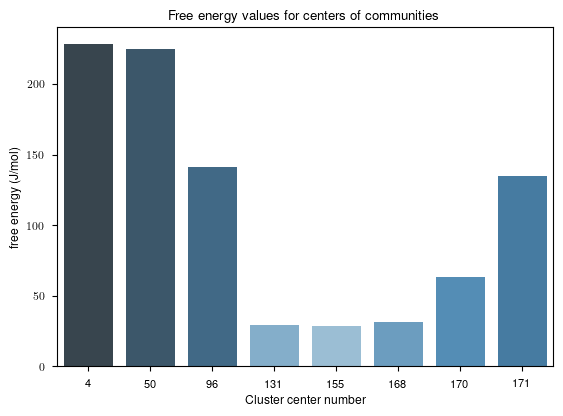

In [ ]:
# find clusters and their centers in the graph
from networkx.algorithms import community
import seaborn as sns
communities = community.girvan_newman(G)
top_level_communities = next(communities)

# get the communities and their centers
communities = list(top_level_communities)
centers = []
for comm in communities:
    center = nx.center(G.subgraph(comm))
    centers.append(center)

centers_struct_elems = []
centers_struct_elems_idx = []
for center in centers:
    for node in center:
        centers_struct_elems_idx.append(node)
        centers_struct_elems.append(struct_elem_list[node])

centers_struct_elems_idx.sort()
centers_g_vals = min_g_vals_groups.iloc[centers_struct_elems_idx].reset_index()
print("Centers identified from the clustering", centers_struct_elems_idx)
display("These centers have the corresponding structured elements their microstate", centers_struct_elems)

pal = sns.color_palette('Blues_d', len(centers_struct_elems_idx))
rank = np.array(centers_g_vals.g_part).argsort().argsort()
sns.barplot(x=centers_struct_elems_idx, y=centers_g_vals.g_part, palette=np.array(pal)[rank])
plt.ylabel('free energy (J/mol)')
plt.title('Free energy values for centers of communities')
plt.xlabel('Cluster center number')

plt.show()

# What these indexes imply is that the structured elements at these indexes are the centers of the communities that were identified in the graph.

# This is able to give a much clearer picture of the free energy values that were seen in the earlier free energy plots which involved all combinations. 
# TODO: Can also look at how to use the edge weight data to understand the transitions between the different conformations.

In [ ]:
# calculating frequencies of structured elements in each community
def get_struct_elem_freq(communities, struct_elem_list) -> list:
    struct_elem_freq = []
    struct_elem_dict_center = {}
    for comm in communities:
        temp = []
        center = nx.center(G.subgraph(comm))
        # for each center, get the counts of structured elements in the cluster
        for node in comm:
            temp += struct_elem_list[node]
        
        struct_elem_freq.append({i: temp.count(i) for i in set(temp)})
        struct_elem_dict_center[center[0]] = struct_elem_freq[-1]
    return struct_elem_freq, struct_elem_dict_center

centers_struct_elem_freq = get_struct_elem_freq(communities, struct_elem_list)

print("Frequencies of structured elements in each cluster")
print(centers_struct_elem_freq)
centers_g_vals['frequency'] = centers_struct_elem_freq
display(centers_g_vals)

Frequencies of structured elements in each cluster
([{0: 1, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5, 10: 5, 11: 5, 12: 5, 14: 1, 15: 1, 16: 1}, {0: 1, 1: 1, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5, 10: 5, 11: 5, 12: 5, 13: 5, 15: 1, 16: 1}, {0: 1, 1: 1, 2: 1, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5, 10: 5, 11: 5, 12: 5, 13: 5, 14: 5, 16: 1}, {0: 1, 1: 1, 2: 1, 3: 1, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5, 10: 5, 11: 5, 12: 5, 13: 5, 14: 5, 15: 5}, {0: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1}, {1: 1, 2: 1, 3: 1, 4: 1, 6: 5, 7: 5, 8: 5, 9: 5, 10: 5, 11: 5, 12: 5, 13: 5, 14: 5, 15: 5, 16: 5}, {0: 6, 1: 6, 2: 6, 3: 6, 4: 6, 5: 6, 6: 6, 7: 6, 8: 6, 9: 6, 10: 6, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1}, {1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5, 10: 5, 11: 5, 13: 1, 14: 1, 15: 1, 16: 1}], {131: {0: 1, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5, 10: 5, 11: 5, 12: 5, 14: 1, 15: 1, 16: 1}, 155: {0: 1, 1: 1, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5, 10: 5, 1

ValueError: Length of values (2) does not match length of index (8)

Error: 1.9387045606711586e-26
1.9387045606711586e-26


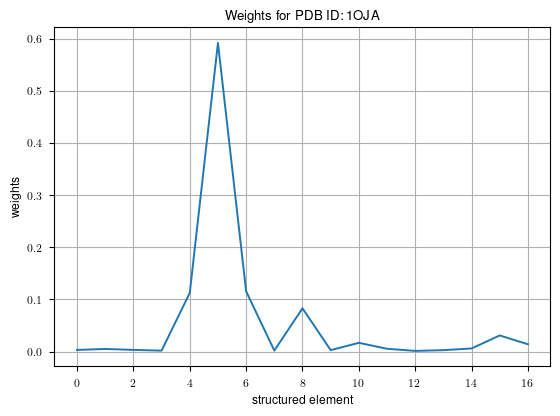

In [ ]:
from sklearn.tree import DecisionTreeRegressor

def create_comb_mat(struct_elem_list, N_PLANES) -> np.array:
    n = len(struct_elem_list)
    comb_mat = np.zeros((n, N_PLANES+1))
    for i in range(n):
        for elem in struct_elem_list[i]:
            comb_mat[i][elem] = 1
    return comb_mat

comb_mat = create_comb_mat(struct_elem_list, N_PLANES)
# print(comb_mat)

def solve_for_weights(comb_mat, g_part) -> np.array:
    np.random.seed(0)
    model = DecisionTreeRegressor(max_depth=15)
    model.fit(comb_mat, g_part)
    
    # error calculation
    error = np.sum(np.square(g_part - model.predict(comb_mat)))
    weights = model.feature_importances_
    residuals = error
    print(f'Error: {error}')

    return weights, residuals

weights, residuals = solve_for_weights(comb_mat, min_g_vals_groups.g_part)
print(residuals)

def plot_weights(weights, id, save = False):
    plt.plot(weights)
    plt.xlabel('structured element')
    plt.ylabel('weights')
    plt.title(f'Weights for PDB ID: {id}')
    plt.grid()
    if save:
        plt.savefig(f'../plots/weights_{id}.jpg')
    plt.show()

plot_weights(weights, id, save = False)

In [ ]:
def generate_distribution(min_g_vals_groups, z_planes):
    arr_dist = []
    for group in min_g_vals_groups:
        order_arr = np.zeros(len(z_planes)+1).astype(int)
        for row in group.iterrows():
            s1 = int(row[1].start1)
            e1 = int(row[1].end1)
            s2 = int(row[1].start2)
            e2 = int(row[1].end2)

            if row[1].type == 1:
                i = s1
                while i <= e1:
                    order_arr[i] += 1
                    i += 1
            
            if row[1].type == 2:
                i = s1
                while i <= e1:
                    order_arr[i] += 1
                    i += 1
                i = s2
                while i <= e2:
                    order_arr[i] += 1
                    i += 1
    
        arr_dist.append(order_arr)
    
    return arr_dist

In [ ]:
# #  generate the distribution of interacting blocks
# arr_dist = generate_distribution(min_g_vals_groups, z_planes)
# plt.figure()
# for arr in arr_dist:
#     plt.plot(arr)
# plt.xlabel('Blocks')
# plt.ylabel('Frequency')
# plt.title('Distribution of interacting blocks in groups with minimum free energy values')

In [ ]:
'''
Finding the occurrence of each interacting block in the groups with minimum free energy values
This will give a good idea of the favourably interacting blocks. 
'''
group = min_g_vals_groups
int_blocks = []
for row in group.iterrows():
    row = row[1].astype(int)
    seq1 = list(range(row.start1, row.end1+1))
    seq2 = list(range(row.start2, row.end2+1))
    if len(seq1) != (row.struct_elem +1) and len(seq2) != (row.struct_elem + 1):
        int_blocks += [seq1, seq2]
    else:
        if len(seq1) == row.struct_elem + 1:
            int_blocks += [seq1]
        else:
            int_blocks += [seq2]
        # print(int_blocks)

freq = np.zeros(len(z_planes)+1).astype(int)

for block in int_blocks:
    for elem in block:
        freq[elem] += 1

In [ ]:
freq_dict = {}
for i in range(len(freq)):
    freq_dict[i] = freq[i]

freq_dict = dict(sorted(freq_dict.items(), key=lambda x: x[1], reverse=True))

highest_freq_dict = list(freq_dict.items())[:10]

def max_freq_residues(highest_freq_dict):
    max_freq_residues_ch1 = []
    max_freq_residues_ch2 = []

    for elem, _ in highest_freq_dict:
        block1 = (interchain_intr.loc[interchain_intr.section == elem]).atom1_resnum
        block2 = (interchain_intr.loc[interchain_intr.section == elem]).atom2_resnum
        if block1.empty or block2.empty:
            continue
        max_freq_residues_ch1 += list(block1)
        max_freq_residues_ch2 += list(block2)

    return max_freq_residues_ch1, max_freq_residues_ch2

max_freq_residues_elec1, max_freq_residues_elec2 = max_freq_residues(highest_freq_dict)
max_freq_residues_vdw1, max_freq_residues_vdw2 = max_freq_residues(highest_freq_dict)

#  find frequency of each residue in the interacting blocks with highest frequencies

def count_residue_frequencies_elec(max_freq_residues_elec1, max_freq_residues_elec2):
    res_freq_elec1 = {}
    for res in max_freq_residues_elec1:
        if res in res_freq_elec1:
            res_freq_elec1[res] += 1
        else:
            res_freq_elec1[res] = 1

    res_freq_elec2 = {}
    for res in max_freq_residues_elec2:
        if res in res_freq_elec2:
            res_freq_elec2[res] += 1
        else:
            res_freq_elec2[res] = 1

    res_freq_elec_sorted1 = dict(sorted(res_freq_elec1.items(), key=lambda x: x[1], reverse=True))
    res_freq_elec_sorted2 = dict(sorted(res_freq_elec2.items(), key = lambda x: x[1], reverse = True))
    return res_freq_elec1,res_freq_elec2

res_freq_elec1, res_freq_elec2 = count_residue_frequencies_elec(max_freq_residues_elec1, max_freq_residues_elec2)

print("For Electrostatic interactions: ")
print(f'Residues frequently observed to be interacting in the lowest energy state in chain 1 {res_freq_elec1.keys()}')
print(f'Residues frequently observed to be interacting in the lowest energy state in chain 2 {res_freq_elec2.keys()}')
print('-----------------------------------')

def count_residue_frequencies_vdw(max_freq_residues_vdw1, max_freq_residues_vdw2):
    res_freq_vdw1 = {}
    for res in max_freq_residues_vdw1:
        if res in res_freq_vdw1:
            res_freq_vdw1[res] += 1
        else:
            res_freq_vdw1[res] = 1

    res_freq_vdw2 = {}
    for res in max_freq_residues_vdw2:
        if res in res_freq_vdw2:
            res_freq_vdw2[res] += 1
        else:
            res_freq_vdw2[res] = 1

    # res_freq_vdw_sorted1 = dict(sorted(res_freq_vdw1.items(), key = lambda x: x[1], reverse = True))
    # res_freq_vdw_sorted2 = dict(sorted(res_freq_vdw2.items(), key = lambda x: x[1], reverse = True))
    return res_freq_vdw1,res_freq_vdw2

res_freq_vdw1, res_freq_vdw2 = count_residue_frequencies_vdw(max_freq_residues_vdw1, max_freq_residues_vdw2)

print('For Van der Waals interactions: ')
print(f'Atoms frequently observed to be interacting in the lowest energy state in chain 1 {res_freq_vdw1.keys()}')
print(f'Atoms frequently observed to be interacting in the lowest energy state in chain 2 {res_freq_vdw2.keys()}')
print('-----------------------------------')

For Electrostatic interactions: 
Residues frequently observed to be interacting in the lowest energy state in chain 1 dict_keys([273, 350, 354, 141, 144, 149, 150, 153, 154, 162, 178, 288, 34, 36, 232, 239, 242, 248, 252, 271, 136, 412, 42, 176, 179, 320, 347, 351, 427, 348, 282])
Residues frequently observed to be interacting in the lowest energy state in chain 2 dict_keys([36, 412, 176, 178, 150, 154, 273, 232, 282, 34, 136, 354, 347, 348, 288, 141, 144, 142, 271, 42, 427, 179, 350, 252])
-----------------------------------
For Van der Waals interactions: 
Atoms frequently observed to be interacting in the lowest energy state in chain 1 dict_keys([273, 350, 354, 141, 144, 149, 150, 153, 154, 162, 178, 288, 34, 36, 232, 239, 242, 248, 252, 271, 136, 412, 42, 176, 179, 320, 347, 351, 427, 348, 282])
Atoms frequently observed to be interacting in the lowest energy state in chain 2 dict_keys([36, 412, 176, 178, 150, 154, 273, 232, 282, 34, 136, 354, 347, 348, 288, 141, 144, 142, 271, 42,

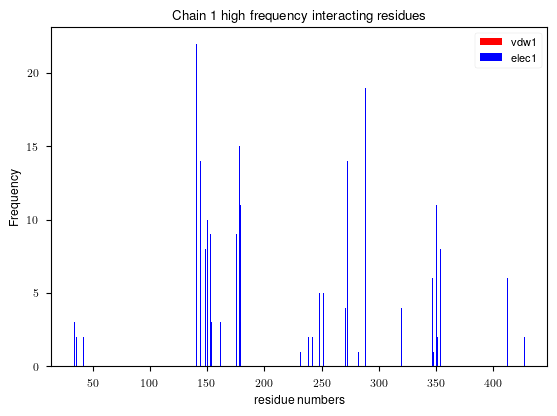

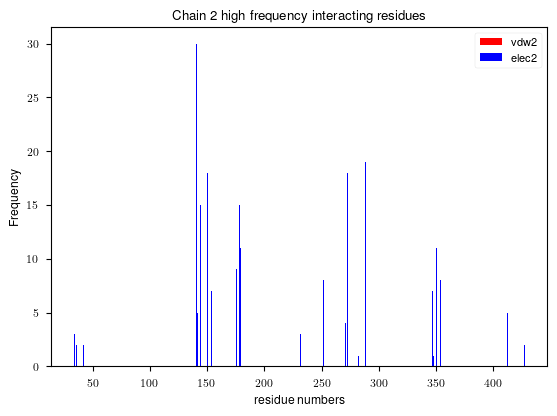

In [ ]:
plt.bar(list(res_freq_vdw1.keys()), list(res_freq_vdw1.values()), color='r', label='vdw1')
plt.bar(list(res_freq_elec1.keys()), list(res_freq_elec1.values()), color='b', label='elec1')

plt.title('Chain 1 high frequency interacting residues')
plt.ylabel('Frequency')
plt.xlabel('residue numbers')
plt.legend()
plt.show()

plt.bar(list(res_freq_vdw2.keys()), list(res_freq_vdw2.values()), color='r', label='vdw2')
plt.bar(list(res_freq_elec2.keys()), list(res_freq_elec2.values()), color='b', label='elec2')

plt.title('Chain 2 high frequency interacting residues')
plt.ylabel('Frequency')
plt.xlabel('residue numbers')
plt.legend()
plt.show()


In [ ]:
def get_block_g_vals(id, min_g_vals_struct_elems):
   master_matrix = pd.read_csv(f'../master_matrix/master_matrix_{id}.csv')
   min_FE_macrostate = min_g_vals_struct_elems[0]
   min_FE_group = master_matrix.groupby('struct_elem').get_group(min_FE_macrostate)

   blockwise_sw = {}
   total_sw = 0
   TEMP = 300
   R = 8.314/1000

   for i in range(len(min_FE_group)):
      row = min_FE_group.iloc[i]
      
      s1 = row.start1
      s2 = row.start2
      e1 = row.end1
      e2 = row.end2
      arr_type = row.type
      sw_part = row.sw_part
      total_sw += sw_part

      if arr_type == 1:
         i = s1
         while i <= e1:
            if i in blockwise_sw.keys():
               blockwise_sw[i] += sw_part
            else:
               blockwise_sw[i] = sw_part
            i+=1
      
      if arr_type == 2:
         i = s1
         while i <= e1:
            if i in blockwise_sw.keys():
               blockwise_sw[i] += sw_part
            else:
               blockwise_sw[i] = sw_part
            i+=1
         i = s2
         while i <= e2:
            if i in blockwise_sw.keys():
               blockwise_sw[i] += sw_part
            else:
               blockwise_sw[i] = sw_part
            i+=1

   blockwise_g_vals = {}
   for i in blockwise_sw.keys():
      blockwise_g_vals[i] = -R*TEMP*math.log(blockwise_sw[i] / total_sw)
   
   blockwise_g_vals = dict(sorted(blockwise_g_vals.items(), key = lambda x: x[0]))
   return blockwise_g_vals


In [ ]:
import pandas as pd
import numpy as np
from collections import defaultdict

def get_block_g_vals2(id, min_g_vals_struct_elems):
    master_matrix = pd.read_csv(f'./master_matrices/{id}_master_matrix.csv')
    min_FE_macrostate = min_g_vals_struct_elems
    # If min_FE_macrostate is a list/set, we need to handle all values
    # Convert set to list if needed
    if isinstance(min_FE_macrostate, (list, set)):
        if len(min_FE_macrostate) > 0:
            # Get the first element if there are any
            min_FE_macrostate = list(min_FE_macrostate)[0]
        else:
            # If empty, look for the minimum free energy element in the data
            sw_sums = master_matrix.groupby('struct_elem')['sw_part'].sum()
            min_FE_macrostate = sw_sums.idxmax()
    
    min_FE_group = master_matrix[master_matrix['struct_elem'] == min_FE_macrostate]

    TEMP = 300
    R = 8.314/1000
    
    blockwise_sw = defaultdict(float)
    total_sw = 0

    for _, row in min_FE_group.iterrows():
        sw_part = row['sw_part']
        total_sw += sw_part

        ranges = [(row['start1'], row['end1'])]
        if row['type'] == 2:
            ranges.append((row['start2'], row['end2']))

        for start, end in ranges:
            for i in range(int(start), int(end) + 1):
                blockwise_sw[i] += sw_part

    log_total_sw = np.log(total_sw)
    blockwise_g_vals = {
        i: -R * TEMP * (np.log(sw) - log_total_sw)
        for i, sw in blockwise_sw.items()
    }

    return dict(sorted(blockwise_g_vals.items()))


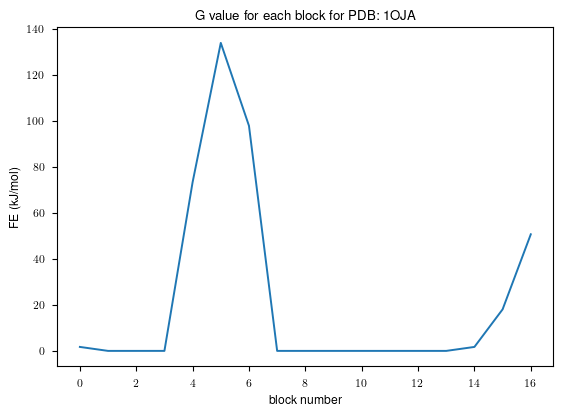

In [ ]:
block_g_vals = get_block_g_vals2(id, list(min_g_vals_struct_elems))

plt.plot(block_g_vals.keys(), block_g_vals.values())    
plt.title(f"G value for each block for PDB: {id}")
plt.xlabel('block number')
plt.ylabel('FE (kJ/mol)')
plt.savefig(f'blockwise_FE/blockwise_{id}.jpg')
plt.show()

In [ ]:
res_elec_list = list(res_freq_elec1.keys()) + list(res_freq_elec2.keys())
res_elec_list = list(set(res_elec_list))

res_vdw_list = list(res_freq_vdw1.keys()) + list(res_freq_vdw2.keys())
res_vdw_list = list(set(res_vdw_list))

res_list = list(set(res_elec_list + res_vdw_list))

def make_mod_pdb_file(id):
    file = f'{id}.pdb'
    with open(file, 'r') as f:
        lines = f.readlines()
    f.close()

    # make a new pdb file with _mod suffix
    if not os.path.exists('../mod_pdb_files'):
        os.makedirs('../mod_pdb_files', exist_ok=True)
    
    with open(f'../mod_pdb_files/{id}_mod.pdb', 'w') as f:
        for line in lines:
            f.write(line)
    f.close()

    return f'../mod_pdb_files/{id}_mod.pdb'

def modify_pdb(res_list, pdb_file_path):

    pandaspdb_obj = pandaspdb.PandasPdb()
    pandaspdb_obj.read_pdb(pdb_file_path)
    df = pandaspdb_obj.df['ATOM']
    pdb_id = pdb_file_path.split('/')[-1].split('.')[0]
    # generate a dict of the z-range for each section
    z_range = {}
    for i in range(len(z_planes)-1):
        z_range[i] = (z_planes[i], z_planes[i+1])

    for row in df.iterrows():
        if row[1].residue_number in res_list:
            z = row[1].z_coord
            for key in z_range.keys():
                if z_range[key][0] <= z <= z_range[key][1]:
                    if key in block_g_vals.keys():
                        df.at[row[0], 'b_factor'] = block_g_vals[key]
                    else:
                        df.at[row[0], 'b_factor'] = 99.99
                    break

    if not os.path.exists('../mod_pdb_files'):
        os.makedirs('../mod_pdb_files', exist_ok=True)

    mod_file_path = f'../mod_pdb_files/{pdb_id}_mod.pdb'

    pandaspdb_obj.df['ATOM'] = df
    pandaspdb_obj.to_pdb(mod_file_path, records=None)
    
    return mod_file_path

pdb_file_path = modify_pdb(res_list, os.path.join(pdb_file_dir, f'{id}.pdb'))

print(f'Modified pdb file {pdb_file_path}')


Modified pdb file ../mod_pdb_files/1OJA_mod.pdb
